In [1]:
#allows plots in notebook
%matplotlib inline
#sets notebook figures to high quality svg
%config InlineBackend.figure_format = 'svg'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#importing ODElib for this demo
import ODElib #current build 0.1.1

In [2]:
#Currently, we need to ignor warnings because they can cause the notebook to crash
import warnings
warnings.filterwarnings('ignore')

# Demo notebook for ODElib 0.1.1 - Modeling Infection States (updated 2-16-2021)
This notebook is meant to demonstrate the versatility of ODElib by investigating the performance of different ODEs with a varying number of infection states. We will guide users through this executable notebook and highlight everything they need to know to get to analyzing their own data!

# Writting your models for ODElib

ODElib requires minimal configuration to start analyzing models, however, it is extremely important that the models, state variables, and parameters are clearly defined. Under the hood, ODElib uses [scipy's integrate module](https://docs.scipy.org/doc/scipy/reference/integrate.html) to numerically solve the ODE. ODElib automates several aspects of using this API as to focus on model testing rather than writing code to eventually test models. As such, ODElib requries only a few key arguments to automate these processes. Foremost, ODElib requires a ODE written as a python function, a list of parameter names that matches the unpacking order in the ODE python funciton, and a list of state variable names that matches the unpacking order in the ODE python function. 

As a demo, we will test the performance of several viral/host infection models. Each model makes a different assumption about the number of infection states in the system. 

In [3]:
# one infected classes
def two_i(y,t,ps):
    '''
    Viral/Host interaction model with two infected classes
    
    State Variables: S (susceptible), V (virus), and I# is the infected state
    
    Parameters: mu (growth rate), phi (infection rate), beta (burst size), lam (lysis rate)
    '''
    mu,phi,beta,lam,tau=ps[0],ps[1],ps[2],ps[3],ps[4]
    #we are now unpacking thre  
    S,I1,I2,V = y[0],y[1],y[2],y[3]
    dSdt = mu*S - phi*S*V
    dI1dt = phi*S*V - tau*I1
    dI2dt = tau*I1 - lam*I2
    dVdt = beta*lam*I2 - phi*S*V
    return np.array([dSdt,dI1dt,dI2dt,dVdt])

# one infected classes
def one_i(y,t,ps):
    '''
    Viral/Host interaction model with one infected class
    
    State Variables: S (susceptible), V (virus), and I# is the infected state
    
    Parameters: mu (growth rate), phi (infection rate), beta (burst size), lam (lysis rate)
    '''
    mu,phi,beta,lam=ps[0],ps[1],ps[2],ps[3]
    #we are now unpacking three variables  
    S,I1,V = y[0],y[1],y[2]
    dSdt = mu*S - phi*S*V
    #we needed to add the new infected class
    dI1dt = phi*S*V - lam*I1
    dVdt = beta*lam*I1 - phi*S*V
    #make sure to add this to the return array
    return np.array([dSdt,dI1dt,dVdt])

#zero infected states
def zero_i_BadEtiquette(y,t,ps):
    '''
    Viral/Host interaction model with zero infected classes
    
    State Variables: S (susceptible) and V (virus)
    
    Parameters: mu (growth rate), phi (infection rate), beta (burst size)
    '''
    #differntial of the susceptible host population
    dSdt = ps[0]*y[0] - ps[1]*y[0]*y[1]
    #differntial of the viral population
    dVdt = ps[2]*ps[1]*y[0]*y[1] - ps[1]*y[0]*y[1]
    return np.array([dSdt,dVdt])

#zero infected states
def zero_i(y,t,ps):
    '''
    Viral/Host interaction model with zero infected classes
    
    State Variables: S (susceptible) and V (virus)
    
    Parameters: mu (growth rate), phi (infection rate), beta (burst size)
    '''
    #Unpacking of parameters
    mu,phi,beta=ps[0],ps[1],ps[2]
    #Unpacking of State Variables
    S,V = y[0],y[1]
    #differntial of the susceptible host population
    dSdt = mu*S - phi*S*V
    #differntial of the viral population
    dVdt = beta*phi*S*V - phi*S*V
    return np.array([dSdt,dVdt])


# Model Formats - Requirements and Etiquette

We have defined 3 ODE models above, each with a different number of infection states. The only requirements needed for a working model are as follows: a `y` argument that passes an array of state variables, a return value that passes the newly calculated differential of each state variable **in the same order**, a `t` argument, and a `ps` argument that passes a array of parameters.

Now we will discuss the things you do not have to do, but really should do. Above are two versions of a model without infected classes (zero_i and zero_i_BadEtiquette). If you were looking at zero_i_BadEtiquette for the first time, you would have no idea the size of the `y` or `ps` array, nor would you have any idea what the parameters are. We **strongly** encourage writing ODEs in a consistent, legible format!  



# Importanting Data
Currently, ODElib accepts data formatted as dataframes. The four columns are required: the organism identification (which matches the state variables), the time, the mean abundance, and the log_sigma. For technical reasons, it necessary to log transform the abundance of your replicates then calculate the standard deviation as to accurately represent the variance. This is important, especially when fitting the model to data.

We have some demo data that is correctly formatted, but the organism names do not match the variable names in the model. We will demonstrate how to quickly relabel data.

In [4]:
df = pd.read_csv("demodata.csv")
df

,organism,time,abundance,log_sigma
0,virus,0.0,10981000,0.059749
1,virus,0.2,12959000,0.227542
2,virus,0.3,13273000,0.257884
3,virus,0.5,17914000,0.219569
4,virus,0.7,15899000,0.296271
5,virus,0.9,13881000,0.281452
6,virus,0.9,15545000,0.221873
7,virus,1.0,14527000,0.364401
8,virus,1.2,12516000,0.476178
9,virus,1.3,32464000,0.636088


In [5]:
df=df.replace({'virus':'V','host':'S'}) #replacing the values for clarity!
df

,organism,time,abundance,log_sigma
0,V,0.0,10981000,0.059749
1,V,0.2,12959000,0.227542
2,V,0.3,13273000,0.257884
3,V,0.5,17914000,0.219569
4,V,0.7,15899000,0.296271
5,V,0.9,13881000,0.281452
6,V,0.9,15545000,0.221873
7,V,1.0,14527000,0.364401
8,V,1.2,12516000,0.476178
9,V,1.3,32464000,0.636088


# Initializing Parameters and ModelFramework class
We will start by initializing a model framework of our zero_i model and the parameters required

#### Parameters
In ODElib, parameters are represented as distributions (specifically [scipy distributions](https://docs.scipy.org/doc/scipy/reference/stats.html)). For each parameter, we need to explicitly indicate which stats distribution generator we will be using and the hyperparameters responsible for shaping the distribution. For example, we will use the [log normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html#scipy.stats.lognorm) scipy distribution for mu, phi and beta. To alter the lognorm distribution, we need to define a dictionary mapping the distribution arguments (as defined in the scipy docs) to their values. In the case of the lognorm stats generator, 's' controls the standard devation, in log space, and 'scale' identifies the mean. 

#### ModelFramework
While the ModelFramework class automates several aspects of analyzing a ODE, it does require some configuration to work correctly. Namely, the `parameter_names` and the `state_names` arguments must be explicitly defined for each model and **must** match the unpacking order of the ODE. For example, our zero_i model function specifies `y` as a tuple of S and V, or`y=(S,V)`. Moreover, `ps` is a tuple of parameters, or `ps = (mu,phi,beta)`.

In [6]:
mu_prior=ODElib.parameter(stats_gen=scipy.stats.lognorm,
                      hyperparameters={'s':3,'scale':1e-8})

phi_prior=ODElib.parameter(stats_gen=scipy.stats.lognorm,
                       hyperparameters={'s':3,'scale':1e-8})
beta_prior=ODElib.parameter(stats_gen=scipy.stats.lognorm,
                        hyperparameters={'s':1,'scale':25})


zeroI=ODElib.ModelFramework(ODE=zero_i,
                          parameter_names=['mu','phi','beta'],
                          state_names = ['S','V'],
                          dataframe=df,
                          mu = mu_prior,
                          phi = phi_prior,
                          beta = beta_prior,
                          t_steps=288
                         )
zeroI

Current Model = __main__.zero_i
Parameters:
	mu = 8.884578240726892e-06   (distribution:lognorm,  hyperparameters:{'s': 3, 'scale': 1e-08})
	phi = 6.118067678939143e-08   (distribution:lognorm,  hyperparameters:{'s': 3, 'scale': 1e-08})
	beta = 28.55676586782267   (distribution:lognorm,  hyperparameters:{'s': 1, 'scale': 25})
Initial States:
	S = 5236900
	V = 10981000

Upon initialization, we can see that parameter values were drawn from their respective distribution. Moreover, you can see that the initial state variable values have been extracted from the dataframe. Lets plot the data!

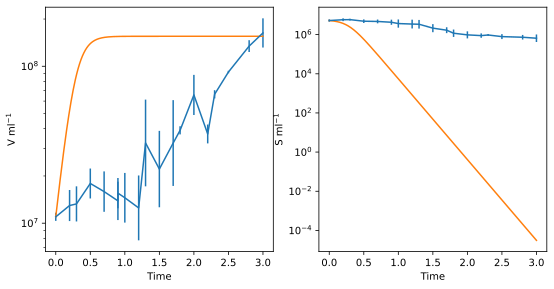

In [7]:
f = zeroI.plot()

# Poor fits
In the figure above, the blue line shows the experimental data with error bars, while the orange line shows the model predictions given the values drawn from the parameter distribution. Unsuprisngly, we find that the randomly drawn paramters do not fit very well.

# Markov chain Monte Carlo (MCMC) fitting procedure
ODElib has a fitting MCMC fitting procedure given the prior distributions. The user has control over the number of markov chains to initialize, the number of iterations per chain, and the number of cpu cores to use for the fitting procedure. Parallelization is possible because markov chains are independent processes, thus in the MCMC call below, we are distributing 32 markov chains among 8 cores.

Because we are dealing with ODEs, poor parameter draws can cause integration to outright fail. Thus, we sample multidimensional space for initial values that are 'good enough' to initialize our markov chains. The number of samples can be defined with `fitsurvey_samples`. `sd_fitdistance` controls what defines a 'good enough' initial fit. Specifically, `sd_fitdistance` defines the average number of standard deviations away model predictions can be from the data. Thus a `sd_fitdistance=3.0` indicates that the initial parameter draws must produce fits at least 3 standard deviations away. Finding good initial fits will be a balance between the range of the prior distributions, the sampling depth in the fit survey, and the standard deviation fit distance.

In [8]:
posterior = zeroI.MCMC(chain_inits=32,iterations_per_chain=1000,
                       cpu_cores=8,fitsurvey_samples=10000,sd_fitdistance=6.0)

Starting 8 processes with 8 cores	[DONE]
Starting 32 processes with 8 cores	[DONE]

Fitting Report
parameter: mu
	median = 1.116e-08, Standard deviation = 1.723e-04
parameter: phi
	median = 1.302e-08, Standard deviation = 4.323e-09
parameter: beta
	median = 1.999e+01, Standard deviation = 5.040e+00

Median parameter fit stats:
	Chi = 2.556e+04
	Adjusted R-squared = -5.837e+00
	AIC = inf


In [9]:
posterior

,mu,phi,beta,chi,iteration,acceptance_ratio,chain#
0,1.480838e-08,1.364223e-08,19.386877,108.070809,501,0.233533,0
1,1.364139e-08,1.352514e-08,19.442711,108.023903,502,0.235060,0
2,1.364139e-08,1.352514e-08,19.442711,108.023903,503,0.234592,0
3,1.364139e-08,1.352514e-08,19.442711,108.023903,504,0.234127,0
4,1.364139e-08,1.352514e-08,19.442711,108.023903,505,0.233663,0
...,...,...,...,...,...,...,...
15963,4.594495e-06,1.334745e-08,19.110142,109.682589,995,0.223116,31
15964,4.594495e-06,1.334745e-08,19.110142,109.682589,996,0.222892,31
15965,4.594495e-06,1.334745e-08,19.110142,109.682589,997,0.222668,31
15966,4.594495e-06,1.334745e-08,19.110142,109.682589,998,0.222445,31


In [10]:
def plot_histogram(series,logspace=True, name=None):
    '''
    This is a plotting function to help us visualize posterior distributions
    '''
    if logspace:
        axessubplot = series.hist(bins=np.logspace(np.log10(series.min()),
                                                   np.log10(series.max()), 50))
        axessubplot.figure.gca().set_xscale("log")
    else:
        axessubplot = series.hist(bins=np.linspace(series.min(),series.max(), 50))
    if series.name or name:
        if name:
            axessubplot.set_title(name)
        else:
            axessubplot.set_title(series.name)
    return(axessubplot)

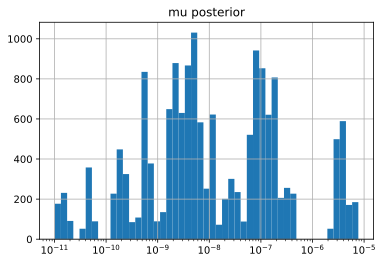

In [11]:
muposterior=plot_histogram(posterior['mu'],name='mu posterior')

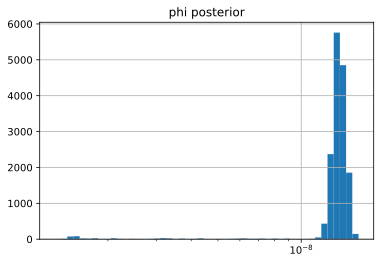

In [12]:
phiposterior=plot_histogram(posterior['phi'],name='phi posterior')

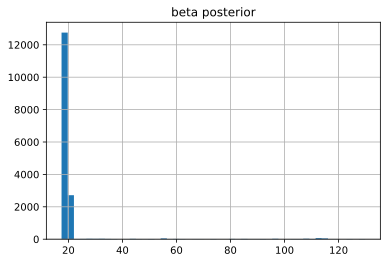

In [13]:
betaposterior=plot_histogram(posterior['beta'],name='beta posterior',logspace=False)

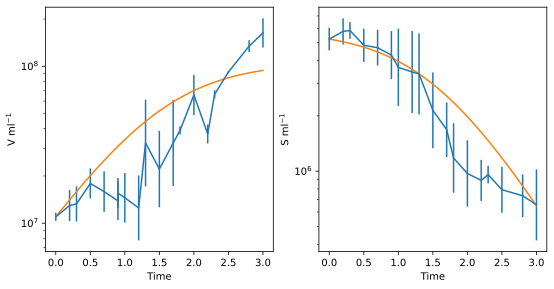

In [14]:
#grabbing a parameter set from the posterior to show fits are much better
zeroI.set_parameters(**posterior.iloc[-1][zeroI.get_pnames()].to_dict())
f,ax=zeroI.plot()

# Results from zeroI ModelFramework
From the posterior distributions above, we find that both phi and beta are fairly constrained given the data, while mu is fairly unconstrained! 


# Exploring different models
Now that we have a basic understanding of ODElib, we can start to rapidly test different mathematical models and test their performance given data and priors! However, we need to cover one more important aspect in configuring the ModelFramework.

## 1 Infection State - 'S' and 'I1' are both hosts
In our one_i model, we assume there is a host 'susceptible' class and a host 'infected' class. In our experimental data, however, we only measure hosts and viruses. In order to properly model 'susceptible' and 'infected' hosts, we must tell our model Framework that hosts are a summation of states `S` and `I1`. Moreover, we must relabel our dataframe to accommodate the naming convention. Moreover, we need to now specify our initial state value for our 'susceptible' class, or `S=5236900`. This must now be user specified because the ModelFramework does not know how to partition the abundance of the initial host time point between `S` and `I1`. By specifying `S=5236900`, we are assuming all hosts are susceptible at the begining of the experiment and none are infected.

Current Model = __main__.one_i
Parameters:
	mu = 7.984472582927986e-10   (distribution:lognorm,  hyperparameters:{'s': 3, 'scale': 1e-08})
	phi = 9.753664635653312e-08   (distribution:lognorm,  hyperparameters:{'s': 3, 'scale': 1e-08})
	beta = 7.330538964846008   (distribution:lognorm,  hyperparameters:{'s': 1, 'scale': 20})
	lam = 0.13641621352334446   (distribution:lognorm,  hyperparameters:{'s': 2, 'scale': 0.1})
Initial States:
	S = 5236900
	I1 = 0
	V = 10981000
Current State Summations
	H=S+I1


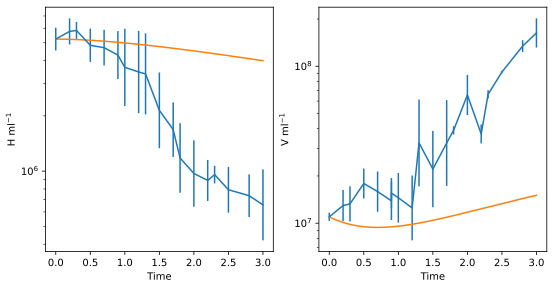

In [15]:
mu_prior=ODElib.parameter(scipy.stats.lognorm,{'s':3,'scale':1e-8})
phi_prior=ODElib.parameter(scipy.stats.lognorm,{'s':3,'scale':1e-8})
beta_prior=ODElib.parameter(scipy.stats.lognorm,{'s':1,'scale':20})
lam_prior=ODElib.parameter(scipy.stats.lognorm,{'s':2,'scale':.1})

df = pd.read_csv("demodata.csv")
df=df.replace({'virus':'V','host':'H'}) #Hosts will now be labeled 'H', which is a summation of S and I1

oneI=ODElib.ModelFramework(ODE=one_i,#Changing the ODE
                          parameter_names=['mu','phi','beta','lam'],#notice we needed to add lam
                          state_names = ['S','I1','V'],# we needed to add infection state 1
                          dataframe=df,
                          mu = mu_prior,
                          phi = phi_prior,
                          beta = beta_prior,
                          lam=lam_prior,
                          state_summations={'H':['S','I1']},#here, we are saying H is a summation of S and I1
                          S=5236900 #ODElib need
                         )
print(oneI)
f=oneI.plot()

In [16]:
#changed sd_fitdistance to allow worse initial fits
posterior_onei = oneI.MCMC(chain_inits=32,cpu_cores=8,fitsurvey_samples=10000,sd_fitdistance=6.0)

Starting 8 processes with 8 cores	[DONE]
Starting 32 processes with 8 cores	[DONE]

Fitting Report
parameter: mu
	median = 1.238e-08, Standard deviation = 8.075e-05
parameter: phi
	median = 3.550e-08, Standard deviation = 6.765e-08
parameter: beta
	median = 1.940e+01, Standard deviation = 8.892e-01
parameter: lam
	median = 1.835e+00, Standard deviation = 8.154e-01

Median parameter fit stats:
	Chi = 6.973e+03
	Adjusted R-squared = -6.656e-01
	AIC = inf


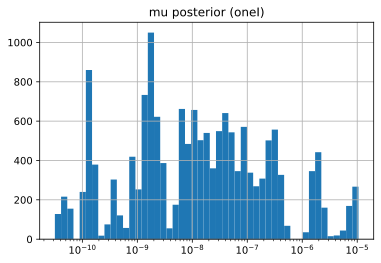

In [17]:
muposterior=plot_histogram(posterior_onei['mu'],name='mu posterior (oneI)')

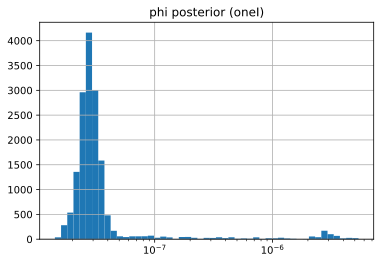

In [18]:
phiposterior=plot_histogram(posterior_onei['phi'],name='phi posterior (oneI)')

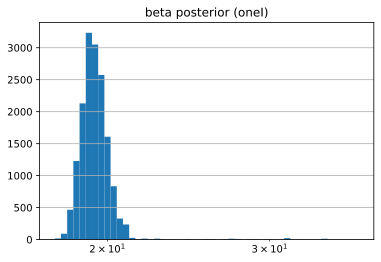

In [19]:
betaposterior=plot_histogram(posterior_onei['beta'],name='beta posterior (oneI)',logspace=True)

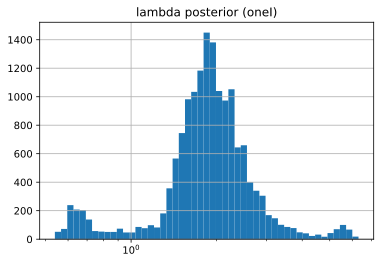

In [20]:
lamposterior=plot_histogram(posterior_onei['lam'],name='lambda posterior (oneI)')

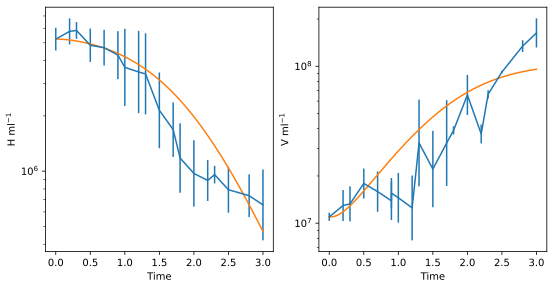

In [21]:
oneI.set_parameters(**posterior_onei.iloc[-1][oneI.get_pnames()].to_dict())#grabbing a single fit from posterior
f,ax=oneI.plot()

# One Infection State Results
We can see that mu is still fairly unconstrained, however, phi and beta are still relativly constrained!

As another example for how to configure the ModelFramework, we will now analyzed two infected states

Current Model = __main__.two_i
Parameters:
	mu = 9.400116070583522e-11   (distribution:lognorm,  hyperparameters:{'s': 3, 'scale': 1e-08})
	phi = 9.628359597177563e-07   (distribution:lognorm,  hyperparameters:{'s': 3, 'scale': 1e-08})
	beta = 120.73861916055267   (distribution:lognorm,  hyperparameters:{'s': 1, 'scale': 20})
	lam = 0.5434869309324085   (distribution:lognorm,  hyperparameters:{'s': 2, 'scale': 0.1})
	tau = 0.0648973204654194   (distribution:lognorm,  hyperparameters:{'s': 2, 'scale': 1})
Initial States:
	S = 5236900
	I1 = 0
	I2 = 0
	V = 10981000
Current State Summations
	H=S+I1+I2
Starting 8 processes with 8 cores	[DONE]
Starting 32 processes with 8 cores	[DONE]

Fitting Report
parameter: mu
	median = 7.475e-09, Standard deviation = 8.047e-07
parameter: phi
	median = 1.069e-07, Standard deviation = 4.120e-06
parameter: beta
	median = 1.973e+01, Standard deviation = 2.951e+00
parameter: lam
	median = 1.934e+00, Standard deviation = 9.528e-01
parameter: tau
	median = 2.7

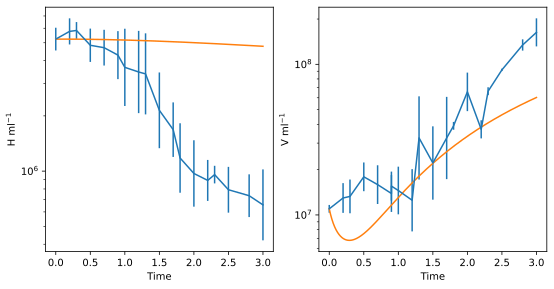

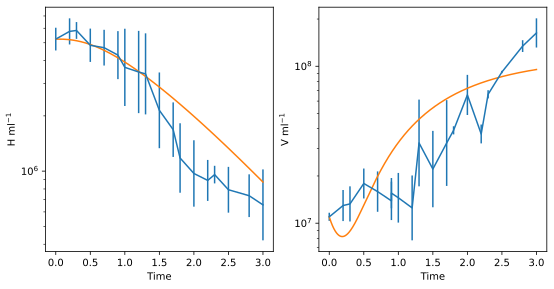

In [22]:
mu_prior=ODElib.parameter(scipy.stats.lognorm,{'s':3,'scale':1e-8})
phi_prior=ODElib.parameter(scipy.stats.lognorm,{'s':3,'scale':1e-8})
beta_prior=ODElib.parameter(scipy.stats.lognorm,{'s':1,'scale':20})
lam_prior=ODElib.parameter(scipy.stats.lognorm,{'s':2,'scale':.1})
tau_prior=ODElib.parameter(scipy.stats.lognorm,{'s':2,'scale':1})

df = pd.read_csv("demodata.csv")
df=df.replace({'virus':'V','host':'H'}) #Hosts will now be labeled 'H', which is a summation of S, I1 and I2

twoI=ODElib.ModelFramework(ODE=two_i,#changing the ODE
                          parameter_names=['mu','phi','beta','lam','tau'],#notice we needed to add tau
                          state_names = ['S','I1','I2','V'],# we needed to add infection state 12
                          dataframe=df,
                          mu = mu_prior,
                          phi = phi_prior,
                          beta = beta_prior,
                          lam=lam_prior,
                          tau = tau_prior,
                          state_summations={'H':['S','I1','I2']},#here, we are saying H= S+I1+I2
                          S=5236900
                         )
print(twoI)
f,ax = twoI.plot()#initial plot
posterior_twoi = twoI.MCMC(chain_inits=32,cpu_cores=8,
                           fitsurvey_samples=10000,sd_fitdistance=6.0)
#grabbing a single fit from posterior
twoI.set_parameters(**posterior_twoi.iloc[-1][twoI.get_pnames()].to_dict())
f,ax=twoI.plot()#fit plot

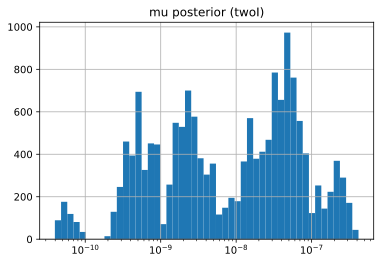

In [23]:
muposterior=plot_histogram(posterior_twoi['mu'],name='mu posterior (twoI)')

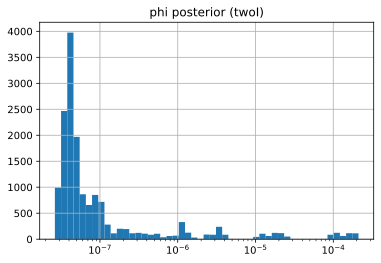

In [24]:
phiposterior=plot_histogram(posterior_twoi['phi'],name='phi posterior (twoI)')

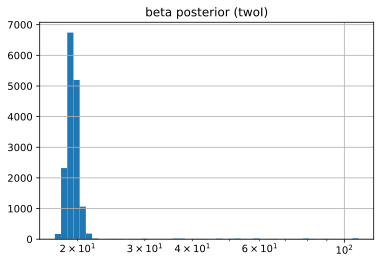

In [25]:
betaposterior=plot_histogram(posterior_twoi['beta'],name='beta posterior (twoI)',logspace=True)

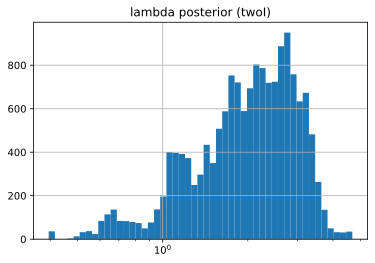

In [26]:
lamposterior=plot_histogram(posterior_twoi['lam'],name='lambda posterior (twoI)')

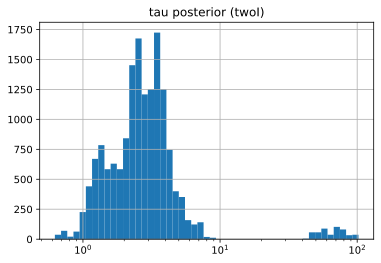

In [27]:
tauposterior=plot_histogram(posterior_twoi['tau'],name='tau posterior (twoI)')

# Bounus trace figures to watch chains changing parameter values
Trace plots. Each color is a different chain

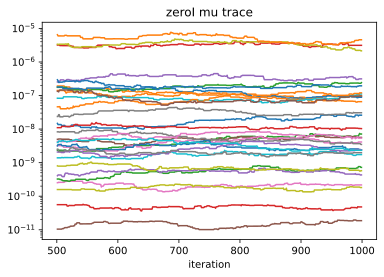

In [28]:
#posterior from zeroi
#ax=posterior[posterior['chain#']==0].plot(x='iteration',y=['mu','phi'],logy=True)
ax=posterior[posterior['chain#']==0].plot(x='iteration',y='mu',logy=True,legend=False,title='zeroI mu trace')
for chain in range(1,posterior['chain#'].max()+1):
    posterior[posterior['chain#']==chain].plot(x='iteration',y='mu',ax=ax,logy=True,legend=False)

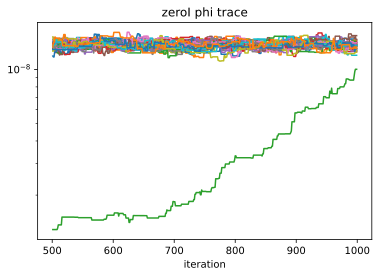

In [29]:
ax=posterior[posterior['chain#']==0].plot(x='iteration',y='phi',logy=True,legend=False,title='zeroI phi trace')
for chain in range(1,posterior['chain#'].max()+1):
    posterior[posterior['chain#']==chain].plot(x='iteration',y='phi',ax=ax,logy=True,legend=False)

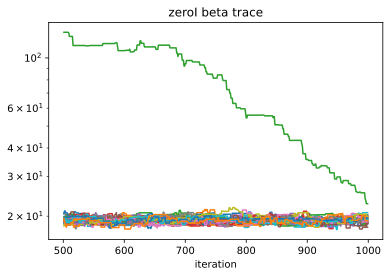

In [30]:
ax=posterior[posterior['chain#']==0].plot(x='iteration',y='beta',logy=True,legend=False,title='zeroI beta trace')
for chain in range(1,posterior['chain#'].max()+1):
    posterior[posterior['chain#']==chain].plot(x='iteration',y='beta',ax=ax,logy=True,legend=False)